In [1]:
# === Evolución de Hrms sobre playa con barra — TG83 como único modelo ===
# Requisitos: numpy, matplotlib, (opcional) scipy
# pip install numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

# Opcionales (para integrar y cargar .mat); el código funciona sin SciPy (usa fallback)
try:
    from scipy.io import loadmat
except Exception:
    loadmat = None
try:
    from scipy.integrate import quad
except Exception:
    quad = None

g = 9.81
rho = 1025.0  # agua de mar

# --------------------------
# Utilidades de dispersión
# --------------------------
def solve_wavenumber(omega: float, h: np.ndarray, tol: float=1e-12, maxit: int=100) -> np.ndarray:
    """Resuelve k(x) para ω^2 = g k tanh(kh) con Newton-Raphson."""
    h = np.asarray(h, float)
    k = np.full_like(h, max(omega**2/g, 1e-9), dtype=float)  # seed
    for _ in range(maxit):
        kh = k*h
        th = np.tanh(kh)
        f  = g*k*th - omega**2
        df = g*(th + kh*(1.0 - th**2))
        step = f / np.maximum(df, 1e-16)
        k = np.maximum(k - step, 1e-12)
        if np.max(np.abs(step)) < tol:
            break
    return k

def group_velocity(omega: float, k: np.ndarray, h: np.ndarray) -> np.ndarray:
    """Cg = n c ; n = 1/2 (1 + 2kh / sinh(2kh))."""
    k = np.asarray(k); h = np.asarray(h)
    c  = omega / np.maximum(k, 1e-16)
    kh = k*h
    n  = 0.5*(1.0 + (2.0*kh)/np.sinh(2.0*np.maximum(kh, 1e-12)))
    return n*c

def Hrms_from_E(E: np.ndarray) -> np.ndarray:
    return np.sqrt(8.0*E/(rho*g))

def E_from_Hrms(Hrms: np.ndarray) -> np.ndarray:
    return 0.125*rho*g*Hrms**2

# --------------------------
# Número de Ursell
# --------------------------
def ursell(Hrms: np.ndarray, k: np.ndarray, h: np.ndarray) -> np.ndarray:
    H = np.sqrt(8.0)*Hrms
    L = 2.0*np.pi/np.maximum(k, 1e-12)
    return H*(L**2)/np.maximum(h, 1e-9)**3


Caso R39: 6 puntos
RMSE = 0.316 m, Bias = 0.275 m


C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:35: RuntimeWarning: overflow encountered in divide
  step = f / np.maximum(df, 1e-16)
C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:34: RuntimeWarning: invalid value encountered in multiply
  df = g*(th + kh*(1.0 - th**2))


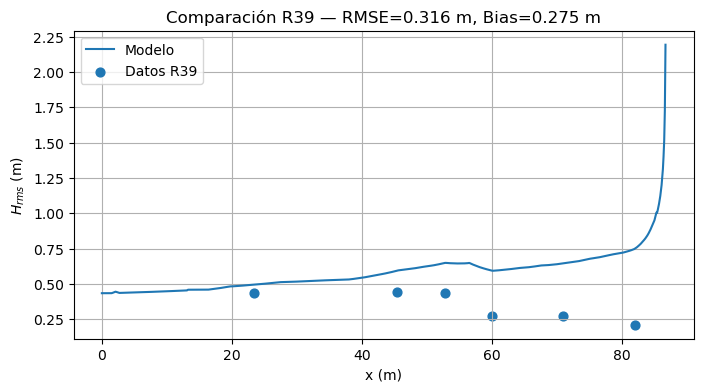

x= 23.45 m | h=  2.21 m | Hrms(model)=0.496 m | Ur=172.64
x= 45.40 m | h=  0.99 m | Hrms(model)=0.594 m | Ur=1051.96
x= 52.73 m | h=  0.68 m | Hrms(model)=0.649 m | Ur=2435.96
x= 60.04 m | h=  0.99 m | Hrms(model)=0.594 m | Ur=1059.67
x= 70.99 m | h=  0.69 m | Hrms(model)=0.646 m | Ur=2348.24
x= 81.97 m | h=  0.38 m | Hrms(model)=0.749 m | Ur=9281.34
Caso R40: 6 puntos
RMSE = 0.171 m, Bias = 0.142 m


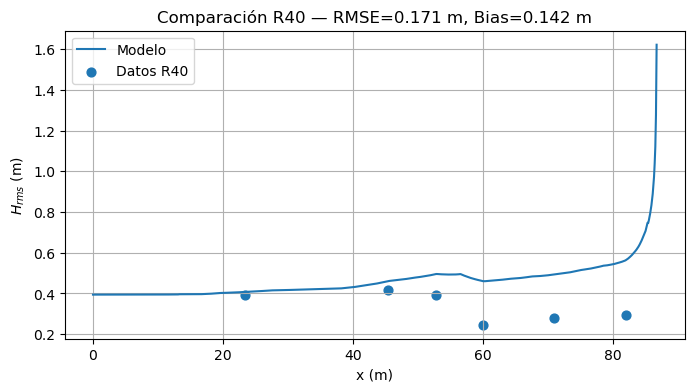

x= 23.45 m | h=  2.21 m | Hrms(model)=0.408 m | Ur= 30.61
x= 45.40 m | h=  0.99 m | Hrms(model)=0.460 m | Ur=191.13
x= 52.73 m | h=  0.68 m | Hrms(model)=0.495 m | Ur=445.02
x= 60.04 m | h=  0.99 m | Hrms(model)=0.460 m | Ur=192.54
x= 70.99 m | h=  0.69 m | Hrms(model)=0.494 m | Ur=428.92
x= 81.97 m | h=  0.38 m | Hrms(model)=0.563 m | Ur=1704.44
Caso R27: 6 puntos
RMSE = 0.180 m, Bias = 0.159 m


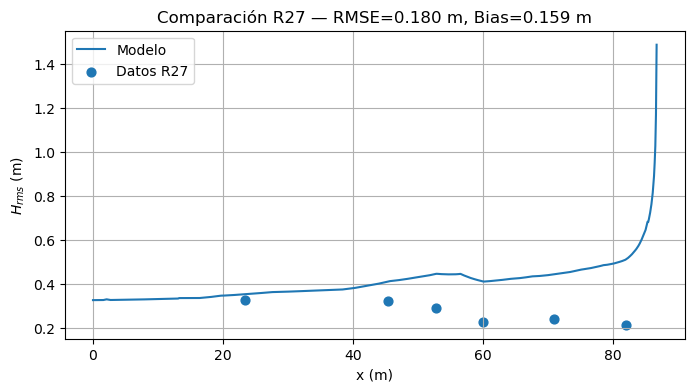

x= 23.45 m | h=  2.21 m | Hrms(model)=0.355 m | Ur= 44.76
x= 45.40 m | h=  0.99 m | Hrms(model)=0.412 m | Ur=275.99
x= 52.73 m | h=  0.68 m | Hrms(model)=0.447 m | Ur=640.86
x= 60.04 m | h=  0.99 m | Hrms(model)=0.413 m | Ur=278.02
x= 70.99 m | h=  0.69 m | Hrms(model)=0.445 m | Ur=617.72
x= 81.97 m | h=  0.38 m | Hrms(model)=0.512 m | Ur=2448.21
Caso R26: 6 puntos
RMSE = 0.118 m, Bias = 0.102 m


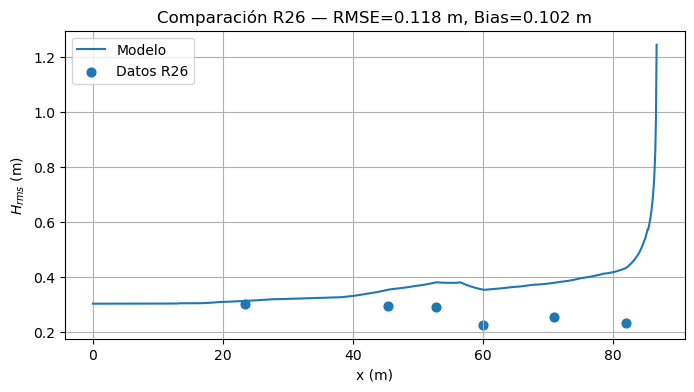

x= 23.45 m | h=  2.21 m | Hrms(model)=0.313 m | Ur= 23.49
x= 45.40 m | h=  0.99 m | Hrms(model)=0.353 m | Ur=146.66
x= 52.73 m | h=  0.68 m | Hrms(model)=0.380 m | Ur=341.48
x= 60.04 m | h=  0.99 m | Hrms(model)=0.353 m | Ur=147.74
x= 70.99 m | h=  0.69 m | Hrms(model)=0.379 m | Ur=329.12
x= 81.97 m | h=  0.38 m | Hrms(model)=0.432 m | Ur=1307.87


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

# 1) Cargar batimetría (REU2004bathy.txt): x en m, z es cota (SWL=0). Profundidad h = -z.
bathy = np.loadtxt("REU2004bathy.txt", comments="%", dtype=float)
x_bathy = bathy[:,0]
z_bathy = bathy[:,1]
h_bathy = -z_bathy  # profundidad positiva hacia abajo

# Utilidad: interpolar profundidad al eje que usemos
def depth_on(x_query):
    return np.interp(x_query, x_bathy, h_bathy)

# 2) Posiciones de sensores (si el .mat no trae x)
x_gauges_default = np.array([23.45, 45.40, 52.73, 60.04, 70.99, 81.97])  # CaHa08
# Si quieres forzar estas posiciones, pon force_default_gauges=True
force_default_gauges = False  # cámbialo a True si tus .mat no traen coordenadas
# Periodos por caso (desde tabla del paper)
T_by_run = {"R39": 8.0, "R40": 4.0, "R26": 4.0, "R27": 5.0}  # s

def load_run_H(mat_path, struct_hint=None):
    M = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    key = struct_hint
    if key is None:
        for k in M.keys():
            if k.startswith("R") and hasattr(M[k], "LWF"):
                key = k; break
    if key is None:
        raise KeyError(f"No encuentro estructura RXX con LWF en {mat_path}")
    R = M[key]
    # H medido
    try:
        H_meas = np.array(R.LWF.H).astype(float).ravel()
    except Exception:
        raise KeyError("No se pudo leer RXX.LWF.H")
    # x de sensores (si existe)
    x_meas = None
    for cand in ["x","X","xg","xpos","x_gauges"]:
        if hasattr(R.LWF, cand):
            arr = np.array(getattr(R.LWF, cand)).astype(float).ravel()
            if arr.size == H_meas.size:
                x_meas = arr; break
    return key, H_meas, x_meas

def compare_one_run(mat_path):
    run_id, H_meas, x_meas = load_run_H(mat_path)
    run_name = run_id  # "R39" o "R40", etc.
    print(f"Caso {run_name}: {len(H_meas)} puntos")

    # Coordenadas de sensores
    if (x_meas is None) or force_default_gauges:
        x_sens = x_gauges_default.copy()
    else:
        x_sens = np.array(x_meas, float)

    # 3) Profundidad en los sensores
    h_sens = depth_on(x_sens)

    # 4) Preparar el dominio del modelo (misma malla que batimetría para evitar interpolaciones fuertes)
    x_model = x_bathy.copy()
    h_model = h_bathy.copy()

    # 5) Condiciones offshore: calibrar Hrms0 con el PRIMER sensor (para evitar ambigüedad Ho↔Hrms)
    # Hrms0_model = H_meas[0]  # "calibración offshore directa"
    # Alternativa: usar valor profundo promedio en una ventana offshore si tienes >1 sensor offshore
    Hrms0_model = float(H_meas[0])

    # Periodo desde la tabla
    T = T_by_run.get(run_name, None)
    if T is None:
        raise ValueError(f"No tengo T para {run_name}. Agrégalo en T_by_run.")

    # 6) Correr el modelo (sin rotura para la 1a parte; luego puedes poner use_breaking=True)
    bc = OffshoreBC(Hrms0=Hrms0_model, T=T)
    res_model = propagate(x_model, h_model, bc, use_breaking=False)  # para la primera entrega
    # Si quieres probar TG83: use_breaking=True y ajustar TG83Params(B, gamma_b)
    # res_model = propagate(x_model, h_model, bc, use_breaking=True, tgpars=TG83Params(B=1.0, gamma_b=0.78))

    # 7) Muestrear modelo en posiciones de sensores
    Hrms_model_at_sens = np.interp(x_sens, res_model["x"], res_model["Hrms"])

    # 8) Métricas
    err = Hrms_model_at_sens - H_meas
    rmse = np.sqrt(np.mean(err**2))
    bias = np.mean(err)

    print(f"RMSE = {rmse:.3f} m, Bias = {bias:.3f} m")

    # 9) Gráficas
    plt.figure(figsize=(8,4))
    plt.plot(res_model["x"], res_model["Hrms"], label="Modelo")
    plt.scatter(x_sens, H_meas, s=40, marker='o', label=f"Datos {run_name}")
    plt.xlabel("x (m)"); plt.ylabel("$H_{rms}$ (m)")
    plt.title(f"Comparación {run_name} — RMSE={rmse:.3f} m, Bias={bias:.3f} m")
    plt.grid(True); plt.legend(); plt.show()

    # 10) (Opcional) Ursell en sensores (usando k(x) del modelo)
    omega = res_model["omega"]
    k_model = res_model["k"]
    # Función Ursell igual a la de tu notebook
    def ursell(Hrms, k, h):
        H = np.sqrt(8.0)*Hrms
        L = 2*np.pi/np.maximum(k,1e-12)
        return H*(L**2)/np.maximum(h,1e-9)**3

    Ur_model_at_sens = ursell(Hrms_model_at_sens,
                              np.interp(x_sens, res_model["x"], k_model),
                              h_sens)

    for xi, hi, hm, ur in zip(x_sens, h_sens, Hrms_model_at_sens, Ur_model_at_sens):
        print(f"x={xi:6.2f} m | h={hi:6.2f} m | Hrms(model)={hm:5.3f} m | Ur={ur:6.2f}")

    return {
        "run": run_name,
        "x_sens": x_sens, "H_meas": H_meas,
        "Hrms_model": Hrms_model_at_sens,
        "rmse": rmse, "bias": bias
    }

# ---- Ejecutar para R39 y R40 ----
out_R39 = compare_one_run("R39.mat")
out_R40 = compare_one_run("R40.mat")
out_R27 = compare_one_run("R27.mat")
out_R26 = compare_one_run("R26.mat")




C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:35: RuntimeWarning: overflow encountered in divide
  step = f / np.maximum(df, 1e-16)
C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:34: RuntimeWarning: invalid value encountered in multiply
  df = g*(th + kh*(1.0 - th**2))


Figura guardada: Figura_unica_R39_R40.png


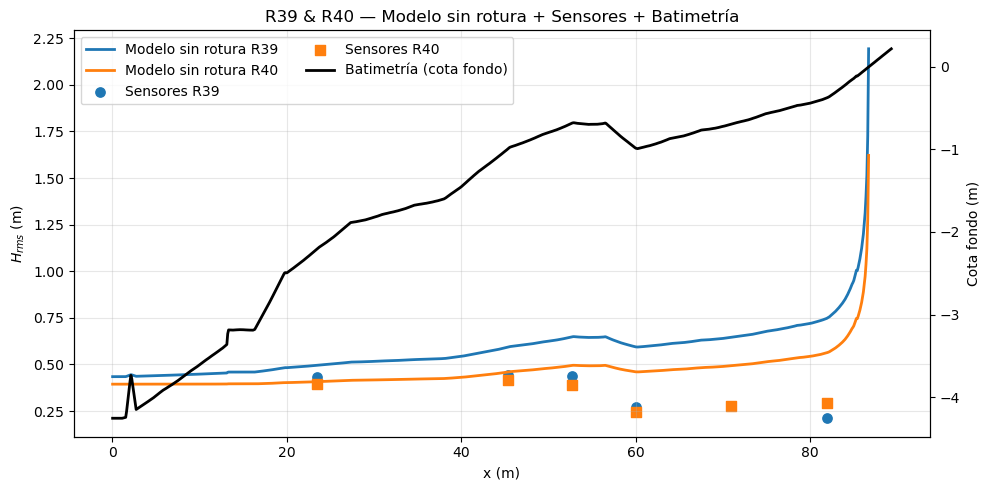

In [21]:
def plot_single_all(x_bathy, h_bathy, out_R39, out_R40,
                    T_R39=8.0, T_R40=4.0, save_png=True, fname="Figura_unica_R39_R40.png"):
    """
    Un solo gráfico con:
      - Batimetría (eje derecho)
      - Modelo SIN ROTURA para R39 y R40 (curvas)
      - Sensores R39 y R40 (puntos)
    """
    # --- Preparar condiciones offshore (calibración con primer sensor) ---
    Hrms0_R39 = float(out_R39["H_meas"][0])
    Hrms0_R40 = float(out_R40["H_meas"][0])
    bc_R39 = OffshoreBC(Hrms0=Hrms0_R39, T=T_R39)
    bc_R40 = OffshoreBC(Hrms0=Hrms0_R40, T=T_R40)

    # --- Correr modelo SIN ROTURA en la malla de batimetría ---
    res_R39_noD = propagate(x_bathy, h_bathy, bc_R39, use_breaking=False)
    res_R40_noD = propagate(x_bathy, h_bathy, bc_R40, use_breaking=False)

    # --- Preparar figura con doble eje (Hrms vs batimetría) ---
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()  # eje derecho para batimetría

    # Curvas del modelo (Hrms)
    h1, = ax.plot(res_R39_noD["x"], res_R39_noD["Hrms"], lw=2, label="Modelo sin rotura R39")
    h2, = ax.plot(res_R40_noD["x"], res_R40_noD["Hrms"], lw=2, label="Modelo sin rotura R40")

    # Puntos de sensores
    sc1 = ax.scatter(out_R39["x_sens"], out_R39["H_meas"], s=45, marker="o", label="Sensores R39")
    sc2 = ax.scatter(out_R40["x_sens"], out_R40["H_meas"], s=45, marker="s", label="Sensores R40")

    # Batimetría (eje derecho). Recordar que h>0 hacia abajo, graficamos cota = -h
    btm, = ax2.plot(x_bathy, -h_bathy, "k-", lw=2, label="Batimetría (cota fondo)")

    # Etiquetas y formato
    ax.set_xlabel("x (m)")
    ax.set_ylabel("$H_{rms}$ (m)")
    ax2.set_ylabel("Cota fondo (m)")  # cota negativa hacia abajo
    ax.grid(True, alpha=0.3)

    # Leyenda combinada (curvas + puntos + batimetría)
    lines = [h1, h2, sc1, sc2, btm]
    labels = [ln.get_label() for ln in lines]
    ax.legend(lines, labels, loc="upper left", ncol=2)

    plt.title("R39 & R40 — Modelo sin rotura + Sensores + Batimetría")
    plt.tight_layout()
    if save_png:
        plt.savefig(fname, dpi=200, bbox_inches="tight")
        print(f"Figura guardada: {fname}")
    plt.show()


# === Ejecuta la figura única ===
plot_single_all(x_bathy, h_bathy, out_R39, out_R40,
                T_R39=8.0, T_R40=4.0,
                save_png=True, fname="Figura_unica_R39_R40.png")


C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:35: RuntimeWarning: overflow encountered in divide
  step = f / np.maximum(df, 1e-16)
C:\Users\alici\AppData\Local\Temp\ipykernel_22640\3577253545.py:34: RuntimeWarning: invalid value encountered in multiply
  df = g*(th + kh*(1.0 - th**2))


Figura guardada: Figura_unica_R39_R40_gamma042.png


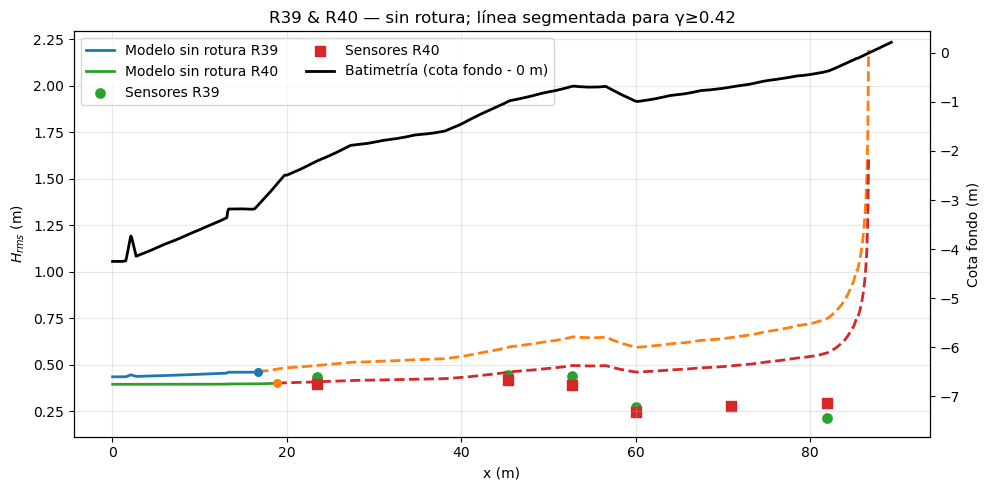

In [18]:
def plot_single_all(x_bathy, h_bathy, out_R39, out_R40,
                    T_R39=8.0, T_R40=4.0,
                    offset=2.0,                 # desplazar batimetría (m)
                    gamma_thresh=0.42,          # umbral γ = H/h para trazar segmentado
                    save_png=True, fname="Figura_unica_R39_R40_gamma042.png"):
    """
    Un solo gráfico con:
      - Batimetría (eje derecho, desplazada)
      - Modelo SIN ROTURA para R39 y R40, sólido hasta γ<gamma_thresh y segmentado después
      - Sensores R39 y R40 (puntos)
    """
    # --- Condiciones offshore ---
    Hrms0_R39 = float(out_R39["H_meas"][0])
    Hrms0_R40 = float(out_R40["H_meas"][0])
    bc_R39 = OffshoreBC(Hrms0=Hrms0_R39, T=T_R39)
    bc_R40 = OffshoreBC(Hrms0=Hrms0_R40, T=T_R40)

    # --- Modelo sin rotura ---
    res_R39 = propagate(x_bathy, h_bathy, bc_R39, use_breaking=False)
    res_R40 = propagate(x_bathy, h_bathy, bc_R40, use_breaking=False)

    # --- Función auxiliar para trazar con cambio de estilo en γ ---
    def plot_with_gamma(ax, res, label_base):
        x = res["x"]
        Hrms = res["Hrms"]
        h = res["h"]
        H = np.sqrt(8.0) * Hrms
        gamma = H / np.maximum(h, 1e-9)

        # índice del primer punto donde γ >= umbral
        idx = np.argmax(gamma >= gamma_thresh)
        crossed = np.any(gamma >= gamma_thresh)

        if not crossed or idx == 0:
            # nunca cruza: traza todo sólido
            return ax.plot(x, Hrms, lw=2, label=f"{label_base}")[0]

        # tramo sólido hasta antes del cruce
        h_solid = ax.plot(x[:idx], Hrms[:idx], lw=2, label=f"{label_base}")[0]
        # tramo segmentado desde el cruce (incluyendo el punto de cruce)
        ax.plot(x[idx:], Hrms[idx:], lw=2, ls="--", label=f"{label_base} (γ≥{gamma_thresh:g})")
        # marca el punto de cruce
        ax.scatter([x[idx]], [Hrms[idx]], s=30, zorder=5)
        return h_solid

    # --- Figura ---
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()

    # Curvas del modelo con cambio de estilo por γ
    h1 = plot_with_gamma(ax, res_R39, "Modelo sin rotura R39")
    h2 = plot_with_gamma(ax, res_R40, "Modelo sin rotura R40")

    # Puntos de sensores
    sc1 = ax.scatter(out_R39["x_sens"], out_R39["H_meas"], s=45, marker="o", label="Sensores R39")
    sc2 = ax.scatter(out_R40["x_sens"], out_R40["H_meas"], s=45, marker="s", label="Sensores R40")

    # Batimetría desplazada y “empujada” abajo
    z_plot = (-h_bathy) - offset
    btm, = ax2.plot(x_bathy, z_plot, "k-", lw=2,
                    label=f"Batimetría (cota fondo - {offset} m)")
    zmin, zmax = z_plot.min(), z_plot.max()
    pad = (zmax - zmin)
    ax2.set_ylim(zmin - 0.8*pad, zmax + 0.05*pad)

    # Etiquetas y formato
    ax.set_xlabel("x (m)")
    ax.set_ylabel("$H_{rms}$ (m)")
    ax2.set_ylabel("Cota fondo (m)")
    ax.grid(True, alpha=0.3)

    # Leyenda combinada
    lines = [h1, h2, sc1, sc2, btm]
    labels = [ln.get_label() for ln in lines]
    ax.legend(lines, labels, loc="upper left", ncol=2)

    plt.title(f"R39 & R40 — sin rotura; línea segmentada para γ≥{gamma_thresh:g}")
    plt.tight_layout()
    if save_png:
        plt.savefig(fname, dpi=200, bbox_inches="tight")
        print(f"Figura guardada: {fname}")
    plt.show()
plot_single_all(x_bathy, h_bathy, out_R39, out_R40,
                T_R39=8.0, T_R40=4.0,
                offset=0,
                gamma_thresh=0.42,
                save_png=True,
                fname="Figura_unica_R39_R40_gamma042.png")

In [19]:
print("Hrms medido (m):", out_R39["H_meas"])


Hrms medido (m): [0.43463349 0.44434217 0.43911755 0.27326543 0.2764396  0.21149863]


In [20]:
print("Hrms medido (m):", out_R40["H_meas"])

Hrms medido (m): [0.39434467 0.4188273  0.39237218 0.24654196 0.27970234 0.29472784]
